# NER modeling on Indic language dataset.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import collections
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

## Strategy

1. Read the dataset and Preprocess them.
2. Use the LSTM based many to many modeling strategy for classification.
3. Use [IndicFT](https://indicnlp.ai4bharat.org/indicft/#downloads) based word embeddings.
4. Do the classification and report the result in terms of `accuracy` metric.

## Load the dataset

### Dataset description:
After scrolling couple of webs and github repo, I finally found annotated hindi dataset for NER. it can be downloaded from [here](https://drive.google.com/file/d/1lXz5BEm7BUFBY_ETP-mGAxrBddCBL5_i/view?usp=sharing).\
It is given in the `CONLL` format. It consists of 203 annotated training sentences (each word is assosciated with a specific NE) and 21 test sentences.


In [2]:
#train data
sent = []
with open("Data/nertrnweather.txt", 'r') as f:
    for lines in f:
        sent.append(lines)

In [3]:
#test data
test_sent = []
with open("Data/nervalweather.txt", 'r') as f:
    for lines in f:
        test_sent.append(lines)

In [4]:
test_sent

['आज U-date\n',
 'मौसम O\n',
 'कैसा O\n',
 'है O\n',
 '\n',
 'क्या O\n',
 'हरिद्वार U-location\n',
 'में O\n',
 'बहुत O\n',
 'ठंड U-weather_type\n',
 'है O\n',
 'अभी U-date\n',
 '\n',
 'आज U-date\n',
 'इतनी O\n',
 'गर्मी U-weather_type\n',
 'क्यों O\n',
 'है O\n',
 '\n',
 'क्या O\n',
 'मुंबई U-location\n',
 'में O\n',
 'ठंडी U-weather_type\n',
 'है O\n',
 '\n',
 'क्या O\n',
 'पाली U-location\n',
 'में O\n',
 'सर्दी U-weather_type\n',
 'आ O\n',
 'गयी O\n',
 '\n',
 'क्या O\n',
 'आज U-date\n',
 'बारिश U-weather_type\n',
 'हो O\n',
 'सकती O\n',
 'है O\n',
 '\n',
 'किदर O\n',
 'सबसे O\n',
 'ज्यादा O\n',
 'बारिश U-weather_type\n',
 'होती O\n',
 'है O\n',
 '\n',
 'मुंबई U-location\n',
 'में O\n',
 'गर्मी U-weather_type\n',
 'ज्यादा O\n',
 'है O\n',
 'क्या O\n',
 'सूरत U-location\n',
 'से O\n',
 '\n',
 'मौसम O\n',
 'का O\n',
 'हाल O\n',
 'बताओ O\n',
 '\n',
 'आज U-date\n',
 'ज्यादा O\n',
 'ठंड U-weather_type\n',
 'है O\n',
 'क्या O\n',
 '\n',
 'मनाली U-location\n',
 'में O\n',
 'कितनी O\n',
 'ठ

In [5]:
s_id = 0
sentences = []
label = []
labels = []
sentence = []
for el in sent:
#     print(el)
    if el=='\n':
        sentences.append(sentence)
        labels.append(label)
        sentence = []
        label=[]
    else:
        strings = el.strip().split()
        label.append(strings[1])
        sentence.append(strings[0])
    

In [6]:
#test data
test_sentences = []
test_label = []
test_labels = []
test_sentence = []
for el in test_sent:
#     print(el)
    if el=='\n':
        test_sentences.append(test_sentence)
        test_labels.append(test_label)
        test_sentence = []
        test_label=[]
    else:
        strings = el.strip().split()
        test_label.append(strings[1])
        test_sentence.append(strings[0])

In [7]:
# test_labels

## Label encodings

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
ner_labels = [l for el in labels for l in el]


In [10]:
enc = LabelEncoder().fit(ner_labels)
enc.classes_

array(['B-date', 'B-location', 'B-weather_type', 'L-date', 'L-location',
       'L-weather_type', 'O', 'U-date', 'U-location', 'U-weather_type'],
      dtype='<U14')

In [11]:
mapping = dict(zip(enc.classes_, enc.transform(enc.classes_)))
mapping

{'B-date': 0,
 'B-location': 1,
 'B-weather_type': 2,
 'L-date': 3,
 'L-location': 4,
 'L-weather_type': 5,
 'O': 6,
 'U-date': 7,
 'U-location': 8,
 'U-weather_type': 9}

So, there are `nine` unique labels for NER in the given dataset.

## Split the dataset into train and test

In [12]:
x_train, x_test, y_train, y_test =  train_test_split(sentences, labels, test_size=0.2) 
print(f"Number of train sentences: {len(x_train)}\nNumber of test sentences: {len(x_test)}")

Number of train sentences: 162
Number of test sentences: 41


## Tokenization

In [13]:
tokeniser = Tokenizer(oov_token='<oov>')
tokeniser.fit_on_texts(x_train)
tokeniser.word_index

{'<oov>': 1,
 'है': 2,
 'में': 3,
 'क्या': 4,
 'आज': 5,
 'होगी': 6,
 'ज्यादा': 7,
 'बारिश': 8,
 'मौसम': 9,
 'से': 10,
 'गर्मी': 11,
 'कल': 12,
 'इस': 13,
 'कितना': 14,
 'गर्म': 15,
 'सबसे': 16,
 'बार': 17,
 'ठंडा': 18,
 'मुंबई': 19,
 'के': 20,
 'कैसा': 21,
 'की': 22,
 'बर्फ': 23,
 'अभी': 24,
 'रही': 25,
 'मुझे': 26,
 'और': 27,
 'ठंडी': 28,
 'होती': 29,
 'का': 30,
 'जगह': 31,
 'कितनी': 32,
 'अच्छा': 33,
 'दिल्ली': 34,
 'पर': 35,
 'कहां': 36,
 'इंडिया': 37,
 'कब': 38,
 'मनाली': 39,
 'या': 40,
 'चाहिए': 41,
 'गिर': 42,
 'हो': 43,
 'कहा': 44,
 'शिमला': 45,
 'रहेगा': 46,
 'कोलकाता': 47,
 'सूरत': 48,
 'होगा': 49,
 'स्थिति': 50,
 'तुलना': 51,
 'पूर्वानुमान': 52,
 'ये': 53,
 'बैंगलोर': 54,
 'ठंड': 55,
 'हफ्ते': 56,
 'चालू': 57,
 'तापमान': 58,
 'लेह': 59,
 'अगले': 60,
 'हैदराबाद': 61,
 'तक': 62,
 'कैसी': 63,
 'रहा': 64,
 'गया': 65,
 'भी': 66,
 'बढ़ेगा': 67,
 'लगता': 68,
 'कि': 69,
 'दिसंबर': 70,
 'जम्मू': 71,
 'छतरी': 72,
 'रात': 73,
 'कुल्लू': 74,
 'दिन': 75,
 'अपने': 76,
 'हुए': 77,
 'कपडे': 7

In [14]:
# transform the labels
train_labels = [enc.transform(y) for y in y_train]
val_labels = [enc.transform(y) for y in y_test]
test_labels = [enc.transform(y) for y in test_labels]

In [15]:
# test_sentences

In [16]:
max_len = 30
trunc_type='post'

#train data
train_sequences = tokeniser.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, maxlen=max_len, truncating=trunc_type)
train_padded_labels = pad_sequences(train_labels,maxlen=max_len, truncating=trunc_type, value = mapping['O'] )

#validation data
val_sequences = tokeniser.texts_to_sequences(x_test)
val_padded = pad_sequences(val_sequences, maxlen=max_len, truncating=trunc_type)
val_padded_labels = pad_sequences(val_labels, maxlen=max_len, truncating=trunc_type, value = mapping['O'])

#test data
test_sequences = tokeniser.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_len, truncating=trunc_type)
test_padded_labels = pad_sequences(test_labels, maxlen=max_len, truncating=trunc_type, value = mapping['O'])

In [17]:
# test_padded_labels

## Generate word embeddings

In [18]:
!pip install fasttext

In [19]:
import fasttext
model = fasttext.load_model('indicnlp.ft.hi.300.bin')

In [20]:
# create embeedings matrix that we can fit in keras layer
hits = 0
miss = 0
len_vocab = len(tokeniser.word_index)+1
word_vec_mat = np.zeros((len_vocab, 300))

for sentence in x_train:
    for word in sentence:
        if word in model.labels:
            hits+=1
            
            word_vec_mat[tokeniser.word_index[word]] = model.get_word_vector(word)
        else:
            miss+=1
print(f"total number of embeddings found:{hits}")
print(f"Total number of embeddings not found: {miss}")

total number of embeddings found:1137
Total number of embeddings not found: 2


In [21]:
# create Embedding layer
emb_dim=300
embedding_layer = keras.layers.Embedding(len_vocab,
                                         emb_dim, 
                                         embeddings_initializer = keras.initializers.Constant(word_vec_mat),
                                        trainable = False)


# Modeling

In [22]:
model_lstm = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    
#     tf.keras.layers.Dense(len(tags), activation='softmax'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(enc.classes_), activation='softmax')),
])
model_lstm.summary()

2021-11-25 17:28:09.549850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-25 17:28:09.549987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         78600     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          85248     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          650       
Total params: 164,498
Trainable params: 85,898
Non-trainable params: 78,600
_________________________________________________________________


In [23]:
model_lstm.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'] )

In [24]:
#training
num_epochs = 100
history = model_lstm.fit(train_padded, y = train_padded_labels,epochs = num_epochs,  batch_size=8, validation_data=(val_padded, val_padded_labels))

2021-11-25 17:28:11.656378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-25 17:28:11.656663: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-11-25 17:28:12.650477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 17:28:12.829224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 17:28:12.843533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 17:28:13.049323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 17:28:13.072435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 2.0156 - accuracy: 0.8617

2021-11-25 17:28:14.834341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 17:28:14.910287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 17:28:14.920188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 4s 96ms/step - loss: 2.0156 - accuracy: 0.8617 - val_loss: 1.6582 - val_accuracy: 0.9293
Epoch 2/100
21/21 [==============================] - 1s 51ms/step - loss: 0.9105 - accuracy: 0.9239 - val_loss: 0.3052 - val_accuracy: 0.9293
Epoch 3/100
21/21 [==============================] - 1s 51ms/step - loss: 0.2539 - accuracy: 0.9346 - val_loss: 0.2056 - val_accuracy: 0.9447
Epoch 4/100
21/21 [==============================] - 1s 49ms/step - loss: 0.1774 - accuracy: 0.9545 - val_loss: 0.1524 - val_accuracy: 0.9585
Epoch 5/100
21/21 [==============================] - 1s 49ms/step - loss: 0.1348 - accuracy: 0.9642 - val_loss: 0.1228 - val_accuracy: 0.9642
Epoch 6/100
21/21 [==============================] - 1s 50ms/step - loss: 0.1097 - accuracy: 0.9743 - val_loss: 0.1030 - val_accuracy: 0.9740
Epoch 7/100
21/21 [==============================] - 1s 48ms/step - loss: 0.0924 - accuracy: 0.9794 - val_loss: 0.0898 - val_accuracy: 0.9772
Epoch 8/100
21/21 

21/21 [==============================] - 1s 51ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0415 - val_accuracy: 0.9911
Epoch 59/100
21/21 [==============================] - 1s 50ms/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 0.0418 - val_accuracy: 0.9911
Epoch 60/100
21/21 [==============================] - 1s 49ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.0414 - val_accuracy: 0.9911
Epoch 61/100
21/21 [==============================] - 1s 51ms/step - loss: 0.0034 - accuracy: 0.9996 - val_loss: 0.0422 - val_accuracy: 0.9911
Epoch 62/100
21/21 [==============================] - 1s 50ms/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0413 - val_accuracy: 0.9911
Epoch 63/100
21/21 [==============================] - 1s 51ms/step - loss: 0.0032 - accuracy: 0.9996 - val_loss: 0.0417 - val_accuracy: 0.9911
Epoch 64/100
21/21 [==============================] - 1s 50ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0424 - val_accuracy: 0.9911
Epoch 65/100

In [25]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

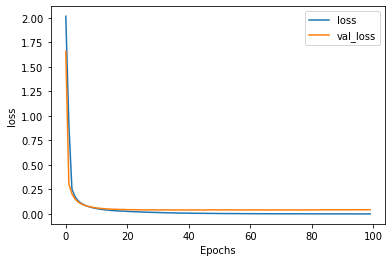

In [26]:
plot_graphs(history, 'loss')

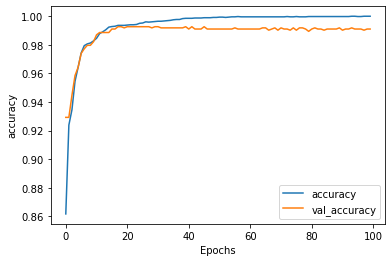

In [27]:
plot_graphs(history, 'accuracy')

## Model evaluation on test data

In [28]:
#train data accuracy
train_loss, train_accuracy = model_lstm.evaluate(x = train_padded, y=train_padded_labels)
print(f"Accuracy for train data: {train_accuracy*100}%")

6/6 [==============================] - 0s 38ms/step - loss: 0.0686 - accuracy: 0.9718
Accuracy for train data: 97.18106985092163%


In [29]:
#test data accuracy
loss, accuracy = model_lstm.evaluate(x = test_padded, y=test_padded_labels)

1/1 [==============================] - 0s 124ms/step - loss: 0.2199 - accuracy: 0.9603


In [30]:
print(f"Accuracy for test data: {accuracy*100}%")

Accuracy for test data: 96.03174924850464%


# Predictive analysis

Since I was able to collect very less number of Indic NER dataset, Therefore, I desined a very simple lstm based model (multiple input and multiple output) that shows very good performance on our test data.
#### Result:
* Train set accuracy: __97.18%__
* Test set accuracy: __96.03%__



The above result may vary a little based on the train and test split as it is random in the notebook.